# Predictions for 2023 </a><a name='top'>

This notebook contains virtually the same code as in the notebook that runs a snowpack simulation. It is applied here to the data from 2022-2023, obtained from a single-point lidar at Finse weather station. Due to the format of the data, which differs from the usual netcdf files, functions had to be re-written to be applicable to time-series data. These functions are the same as the original versions, except for some options that are not available here (ice detection, erosion of several layers, for exemple).

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.

## Imports and functions

In [1]:
%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 7, time 0).


In [2]:
def get_snow_events_timeseries(ds, time_window_std, std_threshold):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold
    We distinguish between accumulation and erosion of snow by looking at the snow depth before and after the event
    Args:
        ds: clean timeseries with 'snow' variable
        time_window_std: size of the rolling window to compute standard deviation
        std_threshold: standard deviation threshold above which the curve is considered to have strong variations > snow event
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    # Compute standard deviation values around each point
    stdev = ds.snow.rolling(time_window_std, center=True).std().values
    
    # Define snow events' timing
    snow_events_occurrences = stdev > std_threshold   # booleans
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    # Initialize variables
    start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices = [], [], [], []
    
    # Identify snow events as accumulations or erosions
    for index in range(len(start_time_indices)):
        
        start_date = start_time_indices[index]
        end_date = end_time_indices[index]
    
        start_snow_height = float(ds.snow.iloc[start_date])
        end_snow_height = float(ds.snow.iloc[end_date])
    
        if start_snow_height < end_snow_height:
            # Accumulation if the snow height rises during the event
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            # Erosion if the snow height falls during the event
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)

In [3]:
def get_change_in_snow_depth_timeseries(ds, start_events, end_events, index_of_event):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: timeseires containing the snow-depth data ('snow' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    # Get timing of event
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    # Get snow heights at start and end of event
    start_snow_height = float(ds.snow.iloc[start_date])
    end_snow_height = float(ds.snow.iloc[end_date])
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

In [4]:
def simulate_snowpack_timeseries(ds, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc_default, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2,
                                met_temp_data=[None], met_wind_data=[None], met_time_data=[0], fit_top_of_snowfall_to_curve=False):
    '''
    Function that simulates the evolution of the snowpack over a certain period of time: at each timestamp, the new density, height and
    temperature of each layer is computed, according to SnowModel (2006)
    Args:
        ds: clean timeseries
        nb_iterations: number of iterations
        
        end_accumulation_times: list of ending times of accumulations in seconds since data starting date
        end_erosion_times: list of ending times of erosions in seconds since data starting date
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        jj: number of layers initially present
        dt: timestep (s)
        ro_layer(1*max_nb_of_layers) array containing density value (kg per m**3) for each layer
        ro_water: density of water (kg per m**3)
        ro_ice: density of ice (kg per m**3)
        t_old: (1*max_nb_of_layers) array containing temperature value (degrees Celcius) for each layer
        tf: ice fusion temperature (degrees Celcius)
        tsfc_default: surface temperature (degrees Celcius)
        dy_snow: (1*max_nb_of_layers) array containing depth value (m) for each layer
        age_layers: (1*max_nb_of_layers) array containing age (s) of each layer
        gamma: (1*max_nb_of_layers) array containing zeros
        cp_snow: thermal capacity of snow (J.kg^-1.K^-1)
        melt_flag: (1*max_nb_of_layers) array containing melt value (1 or 0) for each layer
        a1, a2: exponential parameters, empirically calibrated, a1 in m^-1.s^-1, a2 in m^3.kg^-1

        met_temp_data: array containing surface temperatures for each meteorological timestamp (degrees Celcius), default [None], i.e. use tsfc=tsfc_default
        met_wind_data: array containing wind speed for each meteorological timestamp (m.s^-1), default [None], i.e. use new_snow_ro=150
        met_time_data: array containing the meteorological timestamps (since start of simulation, in s), default [0]

        fit_top_of_snowfall_to_curve: boolean, if True the height of snowfalls will be such that the snow depth is the same as the one measured by lidar, default False
    Returns:
        ro_layer_evolution: list of the states of layers' density (kg.m^-3) through time, format [[ro_layer_1, ro_layer_2, ro_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        depth_evolution: list of the states of layers' depth (m) through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        temperature_evolution: list of the states of layers' temperature (degrees Celcius) through time, format [[temp_layer_1, temp_layer_2, temp_layer_3, ...]_time_1, [...]_time_2, [...], ...]
    '''
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution, depth_evolution, temperature_evolution = [], [], []

    # Initialize surface temperature
    if met_temp_data[0] != None:
        tsfc = float(met_temp_data[0])
    else:
        tsfc = tsfc_default
    
    # Initialize new snow density
    if met_wind_data[0] != None and float(met_wind_data[0]) > 6:
        new_snow_ro = 250
    else:
        new_snow_ro = 150

    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index, erosion_index, temperature_index, wind_index = 0, 0, 0, 0
    
    # Run model
    for i in range(nb_iterations):

        # Update surface temperature if needed
        if temperature_index<len(met_temp_data) and met_time_data[temperature_index]!=None and i*dt>=met_time_data[temperature_index]:
            if met_temp_data[temperature_index] != None:
                tsfc = float(met_temp_data[temperature_index])
            temperature_index += 1
            
        # Update new snow density if needed
        if wind_index<len(met_wind_data) and met_time_data[wind_index]!=None and i*dt>=met_time_data[wind_index]:
            if met_wind_data[wind_index] != None:
                if float(met_wind_data[wind_index]) > 6:
                    new_snow_ro = 250
            else:
                new_snow_ro = 150
            wind_index += 1

        # Detection of accumulations
        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:     # if an accumulation was passed
            if fit_top_of_snowfall_to_curve:
                snow_depth_total = sum(dy_snow[i] for i in range(0,jj))
                ddepth = float(ds.snow_surface.isel(time=end_accumulation[accumulation_index])) - snow_depth_total
            else:
                ddepth = get_change_in_snow_depth_timeseries(ds, start_accumulation, end_accumulation, accumulation_index)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = tsfc
            dy_snow[jj] = ddepth
            age_layers[jj] = (nb_iterations-i) * dt           # age in seconds at end of simulation
            if t_old[jj] <= 0:
                melt_flag[jj] = 0
            else:
                melt_flag[jj] = 1
            jj += 1
            accumulation_index += 1     # next accumulation that will come up
    
        # Detection of erosions
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:     # if an erosion was passed
            ddepth = get_change_in_snow_depth_timeseries(ds, start_erosion, end_erosion, erosion_index)
            erosion_index += 1     # next erosion that will come up
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0
                    ro_layer[jj] = 0
                    t_old[jj] = 0
                    age_layers[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters (fortran code model)
        ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, tf, dy_snow, melt_flag)
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution)

In [5]:
def plot_simul_and_signal_timeseries(ds, depth_evolution, nb_layers_to_plot, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion, ice_layers_times_indices=None,
                          fig_title='Comparison between lidar-measured and simulated snow depth', save_file=False, fig_file_name='my_fig.png', fig_figsize=(15, 7)):
    '''
    Function to plot the simulated snowpack and lidar signal on the same plot
    Args:
        ds: clean timeseries
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        nb_layers_to_plot: number of layers to plot
        data_start_date: first date of the dataset, pandas datetime format
        dt: timestep used in snowpack simulation (s)
        nb_iterations: number of iterations used in snowpack simulation
        
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds

        ice_layers_times_indices: list of time indices where an ice ayer was detected, default None
        
        fig_title: title of the figure, default 'Comparison between lidar-measured and simulated snow depth'
        save_file: boolean, default False
        fig_file_name: name to be given to the saved file, default 'my_fig.png'
        fig_figsize: figure size, default (15, 7)
    Returns:
    '''
    # Construct the data to plot: height of each layer as a function of time
    layers = np.zeros((nb_layers_to_plot, len(depth_evolution)))
    # First layer
    for i in range(len(depth_evolution)):
        layers[0][i] = depth_evolution[i][0]
    # Next layers
    for layer_index in range(1, nb_layers_to_plot):
        for i in range(len(depth_evolution)):
            layers[layer_index][i] = depth_evolution[i][layer_index] + layers[layer_index-1][i]
    
    # Define figure and timestamps
    fig = plt.figure(figsize=fig_figsize)
    times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
    
    # Plot each layer
    for layer_index in range(nb_layers_to_plot):
        plt.plot(times, layers[layer_index], label='layer '+str(layer_index+1))

    # Plot a star at each ice layer detection
    if ice_layers_times_indices != None:
        for time_index in ice_layers_times_indices:
            plt.plot(times[time_index], layers[-1][time_index]+0.001, c='y', marker='*', markersize=15, label='ice layer detected')
        
    # Plot the lidar signal
    ds.snow.plot(c='k', alpha=0.2, label='lidar signal')

    # Plot the start and end of detected snow events on the lidar curve
    ds.iloc[start_accumulation].snow.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
    ds.iloc[end_accumulation].snow.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
    ds.iloc[start_erosion].snow.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
    ds.iloc[end_erosion].snow.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')
    
    plt.ylabel('snow depth (m)')
    plt.xlabel('time (date)')
    
    plt.legend()
    plt.title(fig_title)
    
    if save_file:
        fig.savefig(fig_file_name)
    
    plt.show(block=False)

    return()

## Define parameters </a><a name='fill-in'>

In [6]:
name_of_timeseries_file = '20221001-20220121_finse_meteo_obs.pckl'

start_of_data = '2022-09-30T22:00'
end_of_data = '2023-01-22T14:00'

std_threshold = 0.014

# Snow layers figure

nb_layers_to_plot = 15
figure_size = (16, 8)
save_fig_file = False
fig_file_name = 'snow_layers.png'

[Back to top section](#top)

## Create dataset

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

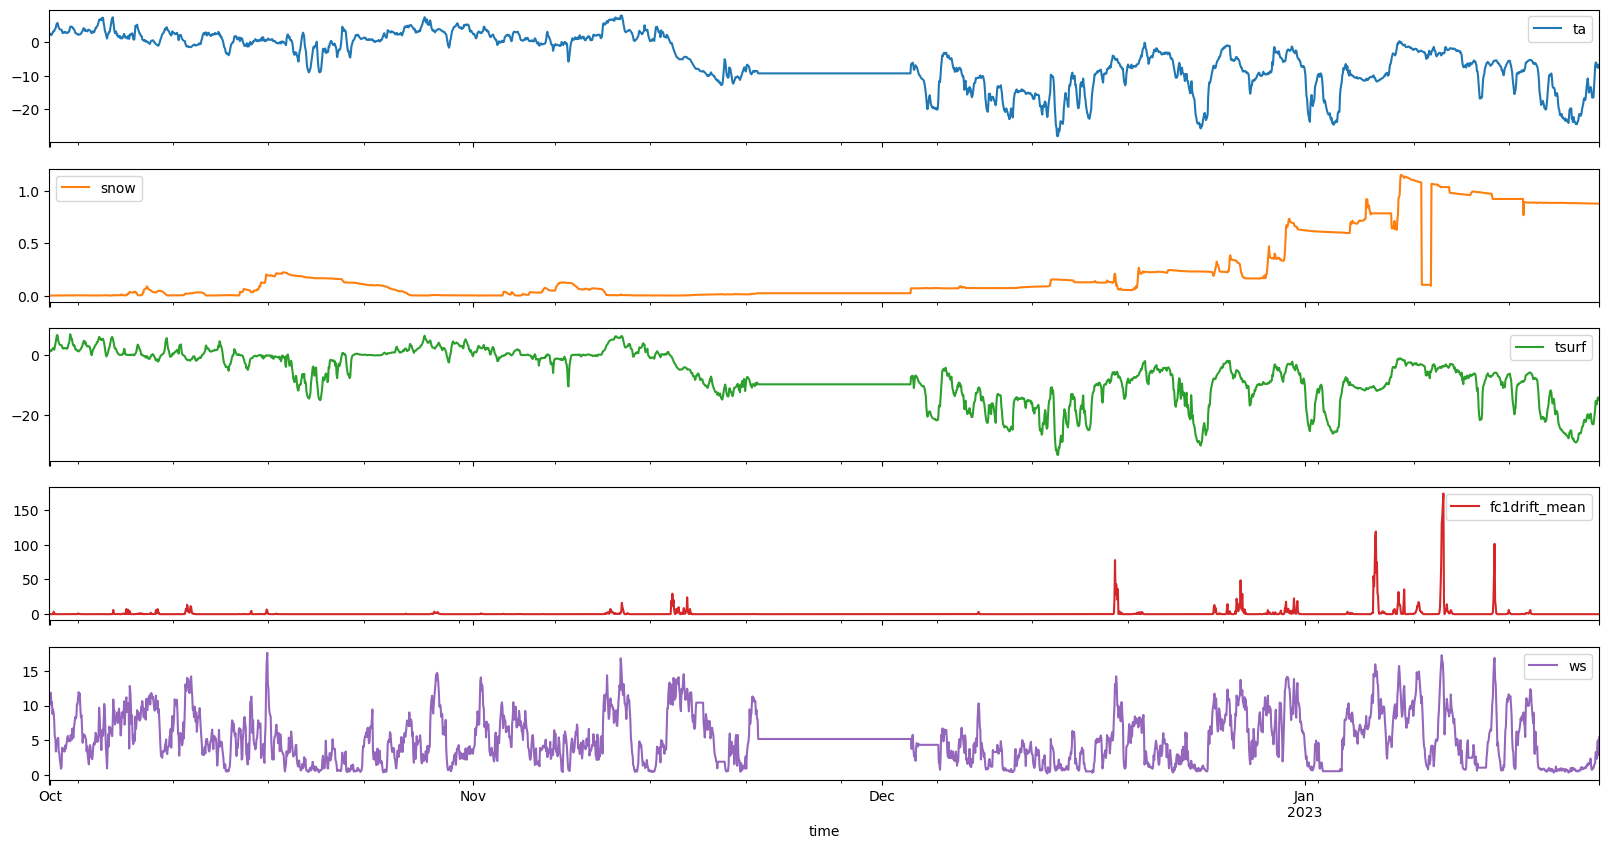

In [7]:
df = pd.read_pickle(name_of_timeseries_file).ffill()
df['snow'] = df['snow'] / 100         # in meters
df[['ta','snow','tsurf','fc1drift_mean', 'ws']].plot(figsize=(20,10), subplots=True)

## Get timing values

In [8]:
# Define dates

data_starting_date_in_ns = (pd.to_datetime(start_of_data).timestamp()) * 1000000000

data_starting_date_in_s = pd.to_datetime(start_of_data).timestamp()
data_ending_date_in_s = pd.to_datetime(end_of_data).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_starting_date = pd.to_datetime(start_of_data)

In [9]:
# Get timing of events

results = get_snow_events_timeseries(df, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = df.index[end_accumulation]
end_accumulation_times = (pd.to_datetime(end_accumulation_times).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = df.index[end_erosion]
end_erosion_times = (pd.to_datetime(end_erosion_times).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


## Simulate snowpack

In [10]:
# Simulate the snowpack

snowpack = simulate_snowpack_timeseries(df, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]


## Plot results

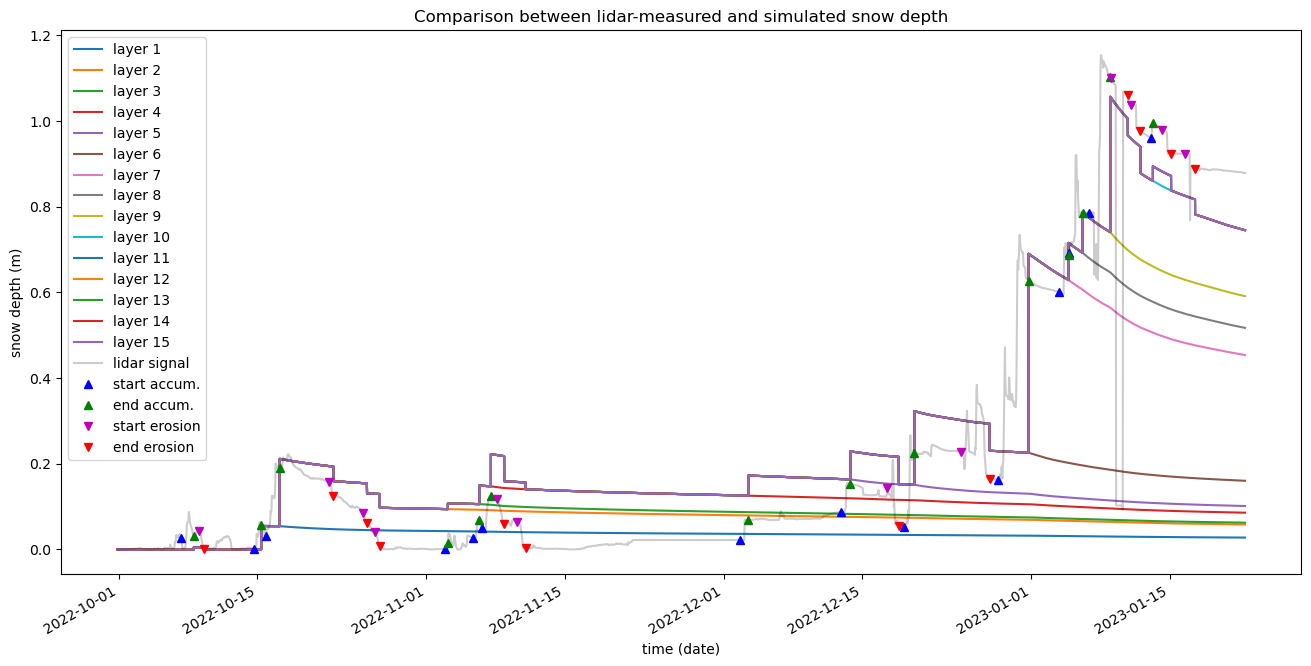

()

In [11]:
plot_simul_and_signal_timeseries(df, depth_evolution, nb_layers_to_plot, pd.to_datetime(start_of_data), dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, fig_figsize=figure_size, save_file=save_fig_file, fig_file_name=fig_file_name)
